# Basic Formulas 

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_rho(lambda_i, N, m, mu_i):
    return lambda_i / (N * m * mu_i)

In [3]:
def compute_pi_0(lambda_i, N, m, mu_i, K):
    rho_i = compute_rho(lambda_i, N, m, mu_i)
    res = 1

    if rho_i != 1:
        res += sum(((m*rho_i) ** k) / sp.factorial(k) for k in range(1, m))
        res += ((1 - (rho_i**(K-m+1)))*pow(m*rho_i, m)) / \
            (sp.factorial(m)*(1-rho_i))

    else:
        res += sum((m**k)/sp.factorial(k) for k in range(1, m))
        res += (m**m) * (K-m+1)/sp.factorial(m)

    return 1/res

In [4]:
def compute_pi_n(lambda_i, N, m, mu_i, K, n):
    pi_0 = compute_pi_0(lambda_i, N, m, mu_i, K)
    rho_i = compute_rho(lambda_i, N, m, mu_i)

    if n < m:
        res = (m*rho_i) ** n / sp.factorial(n)
    else:
        res = (rho_i**n) * (m**m) / sp.factorial(m)

    return res*pi_0

In [5]:
def compute_lambda_dash(lambda_i, N, m, mu_i, K):
    return lambda_i * (1 - compute_pi_n(lambda_i, N, m, mu_i, K, K))/N

In [6]:
def compute_cpu_usage(lambda_i, N, m, mu_i, K):
    u = sum(j*compute_pi_n(lambda_i, N, m, mu_i, K, j) for j in range(0, m))
    u += sum(m*compute_pi_n(lambda_i, N, m, mu_i, K, j)
             for j in range(m+1, K+1))

    u /= m
    return u

In [7]:
def compute_rejection_probablity(lambda_i, N, m, mu_i, K):
    return compute_pi_n(lambda_i, N, m, mu_i, K, K)

# 1. CPU Usage vs Arrival Rate

In [8]:
# no of physical machine, no of VM in physical machine, maximum queue capacity per VM
N, m, K = 10, 15, 100
service_rate = (45, 90, 150)

lambda_values = np.linspace(0, 2*10**4, 100).astype(int)
cpu_usage_values = [[], [], []]

In [9]:
# Calculate CPU usage for each lambda
for lambda_i in lambda_values:
    for i, mu_i in enumerate(service_rate):
        cpu_usage = compute_cpu_usage(lambda_i, N, m, mu_i, K)*100
        cpu_usage_values[i].append(cpu_usage)

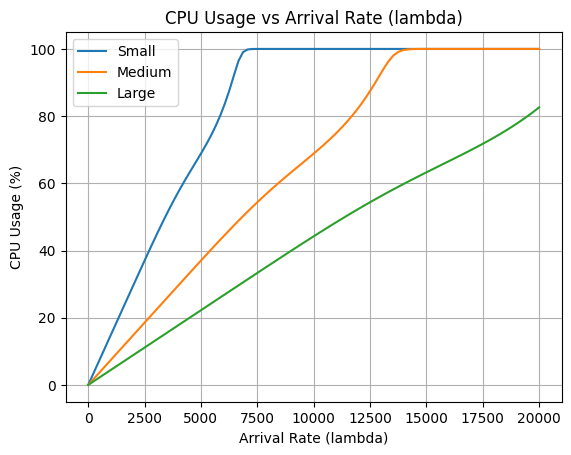

In [10]:
# CPU Usage vs Arrival Rate (lambda)
plt.plot(lambda_values, cpu_usage_values[0], label="Small")
plt.plot(lambda_values, cpu_usage_values[1], label="Medium")
plt.plot(lambda_values, cpu_usage_values[2], label="Large")
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage vs Arrival Rate (lambda)")
plt.grid(True)
plt.legend()
plt.show()

# 2. CPU Usage vs. Number of VMs and Arrival Rate

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [52]:
# Ranges for the variables
lambda_values = np.linspace(1, 2000, 1000).astype(int)  # Adjusted range for lambda
m_values = np.linspace(1, 40, 20).astype(int)  # Adjusted range for VMs

# Create the grid
X, Y = np.meshgrid(lambda_values,m_values)

In [53]:
# Calculate CPU usage for each combination
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        lambda_i = int(X[i, j])
        m = int(Y[i, j])
        cpu_usage = compute_cpu_usage(lambda_i, 1, m, service_rate[1], K) * 100
        Z[i, j] = cpu_usage

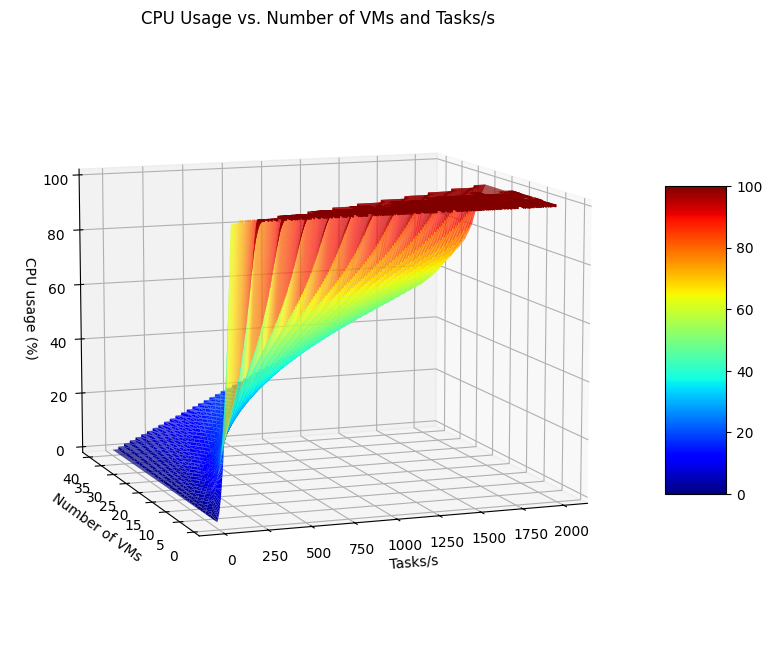

In [54]:
# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the 'jet' color map and increase resolution
surf = ax.plot_surface(X, Y, Z, cmap='jet', rstride=1, cstride=1, edgecolor='none')

# Set labels and title
ax.set_xlabel('Tasks/s')
ax.set_ylabel('Number of VMs')
ax.set_zlabel('CPU usage (%)')
ax.set_title('CPU Usage vs. Number of VMs and Tasks/s')

# Adjust view angle to match the first image
ax.view_init(elev=10, azim=-110,roll=0)

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()